##### Файл - PointzAgregatorPassDotAero

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt 
sns.set_palette("husl")
file_path = "PointzAgregatorPassDotAero.csv"

In [4]:
main_df = pd.read_csv(file_path, sep=";", infer_datetime_format="%d.%m.%Y", na_filter=True,na_values="NULL", dtype={
    "uid": object
})
main_df.dropna(inplace=True)
main_df.head()

,uid,first,last,type,number,bonusprogramm,type2,type3,Code,Date,Departure,Arrival,Fare
0,613142142,IAROMIR,ZVEREV,Airlines,FB 171388778,Flying Blue,Airlines,Flight,KE827,06.08.2017,rea,SZX,YGRPZT
1,613142142,IAROMIR,ZVEREV,Airlines,FB 171388778,Flying Blue,Airlines,Flight,MU9706,26.10.2017,PEK,BSD,YSTNYV
2,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,Airlines,Flight,DL5058,11.09.2017,CHA,ATL,YRSTKY
3,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,Airlines,Flight,KE1,01.04.2017,rea,HNL,PRSTRU
4,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,Airlines,Flight,DL837,13.09.2017,ATL,HNL,YGRPNG


In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436090 entries, 0 to 446171
Data columns (total 12 columns):
uid              436090 non-null object
first_last       436090 non-null object
type             436090 non-null object
number           436090 non-null object
bonusprogramm    436090 non-null object
type2            436090 non-null object
type3            436090 non-null object
Code             436090 non-null object
Date             436090 non-null object
Departure        436090 non-null object
Arrival          436090 non-null object
Fare             436090 non-null object
dtypes: object(12)
memory usage: 43.3+ MB


In [4]:
main_df.nunique()

uid              56943
first_last       45923
type                 1
number           88172
bonusprogramm        4
type2                1
type3                1
Code             23849
Date               366
Departure         1128
Arrival           1126
Fare             10694
dtype: int64

### Преобразование данных и типов

In [5]:
# Убираем колонки с 1 значением
main_df = main_df.drop(columns=["type", "type2", "type3"])

In [6]:
main_df["Date"] = pd.to_datetime(main_df["Date"], format="%d.%m.%Y")
main_df["Departure"] = main_df["Departure"].str.upper()
main_df["Arrival"] = main_df["Arrival"].str.upper()

In [7]:
flighters_count = main_df["number"].value_counts().to_frame().reset_index(col_fill='code')
flighters_count = flighters_count.rename(columns={"index": 'number', 'number': 'flights'})

In [8]:
flighters_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88172 entries, 0 to 88171
Data columns (total 2 columns):
number     88172 non-null object
flights    88172 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [9]:
main_df = pd.merge(main_df, flighters_count, on="number")
main_df.head(3)

,uid,first_last,number,bonusprogramm,Code,Date,Departure,Arrival,Fare,flights
0,613142142,IAROMIR ZVEREV,FB 171388778,Flying Blue,KE827,2017-08-06,REA,SZX,YGRPZT,2
1,613142142,IAROMIR ZVEREV,FB 171388778,Flying Blue,MU9706,2017-10-26,PEK,BSD,YSTNYV,2
2,103197717,VITALINA KOROVINA,KE 696768759,Korean Air SKYPASS,DL5058,2017-09-11,CHA,ATL,YRSTKY,4


### Графики по отдельным данным

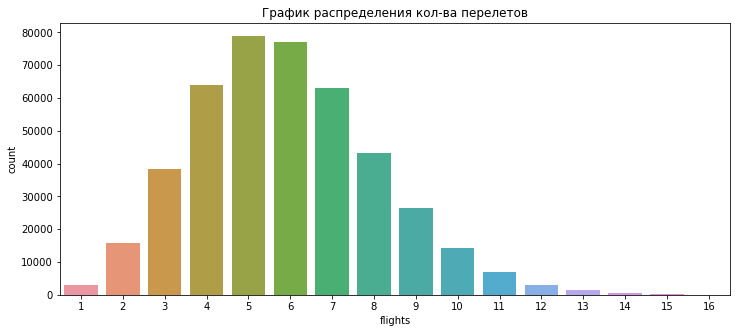

In [10]:
plt.figure(figsize=(12, 5))
plt.title("График распределения кол-ва перелетов")
sns.countplot(x="flights", data=main_df, )

### Находим кол-во перелетов, которое в 2р. меньше, чем самое частое кол-во

In [11]:
flights_freq = main_df["flights"].value_counts()
# Выражаем в процентах
flights_freq /= flights_freq.sum()
# Значения > 5% и != 1, 2
flights_freq = flights_freq[(flights_freq <= flights_freq.max()/2) & (~flights_freq.index.isin([1, 2, 3]))]
flights_freq.sort_values()

16    0.000110
15    0.000344
14    0.001059
13    0.003100
12    0.006659
11    0.015765
10    0.032975
9     0.060717
Name: flights, dtype: float64

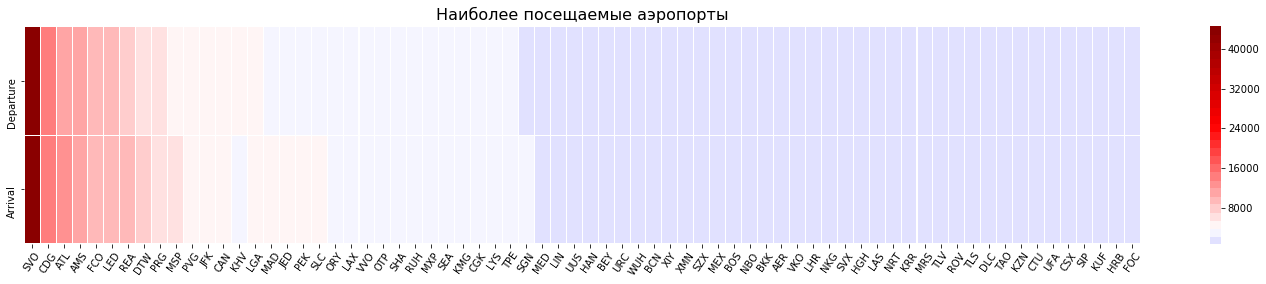

In [12]:
plt.figure(figsize=(25, 4))
plt.title("Наиболее посещаемые аэропорты", fontsize=16)
city_heatmap = main_df[['Departure', 'Arrival']].apply(pd.Series.value_counts) #
city_heatmap = city_heatmap.sort_values(by=['Departure', 'Arrival'], ascending=False)
city_heatmap = city_heatmap.head(70)

sns.heatmap(city_heatmap.T, linewidth=0.02, center=city_heatmap.values.mean(),
            cmap=sns.mpl_palette("seismic", 50))
xt = plt.xticks(rotation=55)


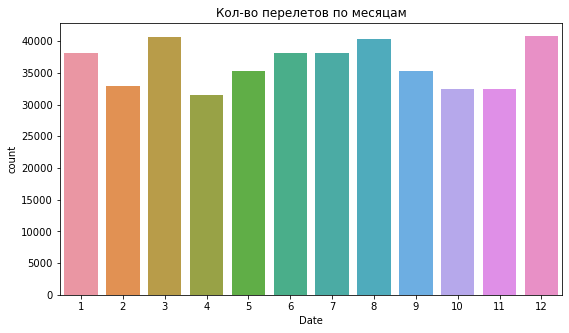

In [13]:
plt.figure(figsize=(9, 5))
plt.title("Кол-во перелетов по месяцам")
sns.countplot(main_df["Date"].dt.month)

### Группирование данных о перелетах по кол-ву перелетов, бонус. прогр., дате, коду перелета 

In [14]:
grouped_df = main_df.groupby(["flights", "bonusprogramm", "Date", "Code"])["uid"].count().reset_index()
# Оставляем данные, где в 1 рейсе есть более 2 пассажиров из списка
grouped_df = grouped_df.loc[(grouped_df["uid"] > 1) & (grouped_df["flights"].isin(flights_freq.index))]
grouped_df

,flights,bonusprogramm,Date,Code,uid
380258,9,Aeroflot Bonus,2017-01-01,SU1395,2
380263,9,Aeroflot Bonus,2017-01-01,SU1491,2
380266,9,Aeroflot Bonus,2017-01-01,SU1537,2
380316,9,Aeroflot Bonus,2017-01-04,SU1531,2
380334,9,Aeroflot Bonus,2017-01-05,SU1459,2
...,...,...,...,...,...
421026,11,Aeroflot Bonus,2017-01-09,SU1383,2
422091,11,Aeroflot Bonus,2017-09-26,DL2971,2
422805,11,Delta SkyMiles,2017-02-20,OK4822,2
424902,11,Flying Blue,2017-03-06,SU1563,2


In [15]:
# Поиск пассажиров с на 1 рейсе с 1-ими хар-ками
from itertools import permutations
grouped_passengers = {}
for index, row in grouped_df[["flights", "bonusprogramm", "Date", "Code"]].iterrows():
    row = list(row.values)
    tmp_df = main_df.loc[ (main_df["flights"] == row[0]) & (main_df["bonusprogramm"] == row[1]) & (main_df["Date"] == row[2]) & (main_df["Code"] == row[3])]
    
    if row[0] in grouped_passengers.keys():
        vals = np.array([tmp_df["uid"].values])
        # print(vals.shape)
        # Если на рейсе более 2 пассажиров, то делаем кобинации
        if vals.shape[1] > 2:
            vals = np.array(list(permutations(vals.reshape(-1,1).tolist(), 2))).reshape(-1, 2)
        
        grouped_passengers[row[0]] = np.append(grouped_passengers[row[0]], vals, axis=0)
        # print(grouped_passengers[row[0]])
    else:
        grouped_passengers.update({row[0]: np.array(tmp_df["uid"].values, ndmin=2)})
        # print("created", row[0])


In [16]:
passenger_freq_df = pd.DataFrame(columns=["uid", "flights_with_other", "fligts_count"])

print("Пассажиры, которые летали не в одиночку")
for key in grouped_passengers.keys():
    print(f"Кол-во людей, которые совершили {key} перелетов = {grouped_passengers[key].shape[0]}")
    passenger_freq = np.reshape(np.unique(grouped_passengers[key], return_counts=True), (-1 ), order="F").reshape(-1, 2)
    passenger_freq = passenger_freq[passenger_freq[:, 1] > 1]
    passenger_freq = np.insert(passenger_freq, 2, key, axis=1)
    passenger_freq_df = passenger_freq_df.append(pd.DataFrame(passenger_freq, columns=["uid", "flights_with_other", "fligts_count"]))

Пассажиры, которые летали не в одиночку
Кол-во людей, которые совершили 9 перелетов = 115
Кол-во людей, которые совершили 10 перелетов = 26
Кол-во людей, которые совершили 11 перелетов = 5


## Пассажиры, совершившие мн-тво перелетов не одни

In [17]:
passenger_freq_df = pd.merge(passenger_freq_df, main_df[["first_last", "uid"]], left_on="uid", right_on="uid", how="inner").drop_duplicates()
# passenger_freq_df = passenger_freq_df.drop(columns=["first_last_x"])
passenger_freq_df

,uid,flights_with_other,fligts_count,first_last
0,171171977,4,9,ALEKSEI KHOKHLOV
14,320860633,6,9,ULYANA PIROGOVA
23,331723808,4,9,ALINA GULYAEVA
32,399994433,4,9,VALENTINA EMELIANOVA
41,402610323,4,9,ALINA RYABOVA
50,463071423,2,9,IGOR KHOKHLOV
70,598873338,6,9,ALISA KOZINA
79,644831620,2,9,MARGARITA LOGINOVA
92,671228478,4,9,SAMIRA TEREKHOVA
116,771589720,2,9,ALENA LEBEDEVA


In [18]:
main_df.columns = main_df.columns.str.upper()

In [39]:
main_df_merged = pd.merge(main_df, passenger_freq_df[["uid", "flights_with_other"]], left_on="UID", right_on="uid", how="left")
main_df_merged = main_df_merged.drop(columns=["uid"])

In [40]:
# Проверка того, что данные добавились
main_df_merged[~main_df_merged["flights_with_other"].isna()].head()

,UID,FIRST_LAST,NUMBER,BONUSPROGRAMM,CODE,DATE,DEPARTURE,ARRIVAL,FARE,FLIGHTS,flights_with_other
41820,644831620,MARGARITA LOGINOVA,FB 294343061,Flying Blue,MU6767,2017-02-16,PVG,SZV,YFLXTD,4,2
41821,644831620,MARGARITA LOGINOVA,FB 294343061,Flying Blue,VN4007,2017-01-19,HAN,SGN,YFLXLE,4,2
41822,644831620,MARGARITA LOGINOVA,FB 294343061,Flying Blue,CZ4815,2017-02-13,TPE,PVG,YSTNPL,4,2
41823,644831620,MARGARITA LOGINOVA,FB 294343061,Flying Blue,SV829,2017-08-29,KUL,MED,YFLXIG,4,2
41824,644831620,MARGARITA LOGINOVA,SU 246267885,Aeroflot Bonus,SU6630,2017-11-15,TLV,ROV,YFLXPG,9,2


In [45]:
main_df_merged.columns = main_df_merged.columns.str.upper()
main_df_merged.head()

,UID,FIRST_LAST,NUMBER,BONUSPROGRAMM,CODE,DATE,DEPARTURE,ARRIVAL,FARE,FLIGHTS,FLIGHTS_WITH_OTHER
0,613142142,IAROMIR ZVEREV,FB 171388778,Flying Blue,KE827,2017-08-06,REA,SZX,YGRPZT,2,NaN
1,613142142,IAROMIR ZVEREV,FB 171388778,Flying Blue,MU9706,2017-10-26,PEK,BSD,YSTNYV,2,NaN
2,103197717,VITALINA KOROVINA,KE 696768759,Korean Air SKYPASS,DL5058,2017-09-11,CHA,ATL,YRSTKY,4,NaN
3,103197717,VITALINA KOROVINA,KE 696768759,Korean Air SKYPASS,KE1,2017-04-01,REA,HNL,PRSTRU,4,NaN
4,103197717,VITALINA KOROVINA,KE 696768759,Korean Air SKYPASS,DL837,2017-09-13,ATL,HNL,YGRPNG,4,NaN


In [46]:
# write_path = "C:\\Users\\callo\\PycharmProjects\\airlines\\normal_data\\PointzAgregatorPassDotAero_ready.csv"
# main_df_merged.to_csv(write_path, sep=";", na_rep="NULL")